In [1]:
# Importing Packages and Libraries
import shap
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pandas as pd
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [2]:
# Load data
file_path = '/Users/paulahofmann/Documents/Coding/Online-Review/FeaturePreperation/Data_with_Features/Final Data/Hedonic_Final.csv'
df = pd.read_csv(file_path)

In [3]:
def calculate_total_helpful_votes(df):
    for product_id, group in df.groupby('product'):
        total_helpful_votes = group['helpful_vote'].sum()
        df.loc[group.index, 'total_helpful_votes'] = total_helpful_votes
        # Initialize the helpful_ratio to 0
        df.loc[group.index, 'helpful_ratio'] = 0
        
        # Calculate helpful_ratio only for reviews with more than 1 helpful vote
        mask = group['helpful_vote'] > 1
        df.loc[group.index[mask], 'helpful_ratio'] = (group['helpful_vote'][mask] / total_helpful_votes) 
    
    return df


In [4]:
df = calculate_total_helpful_votes(df)

In [5]:
df = df[df['helpful_vote'] > 1]

In [6]:
# Drop unnecessary columns
columns_to_drop = ['title_x', 'text', 'images', 'asin', 'parent_asin', 'user_id',
       'timestamp', 'helpful_vote', 'verified_purchase', 'text_cleaned',
       'text_cleaned1','main_category','features','prod_type','neutral_score','day_of_week']
df.drop(columns=columns_to_drop, inplace=True)

In [7]:
# Mapping dictionary for sentiment transformation
sentiment_mapping = {'positive': 2, 'neutral': 1, 'negative': 0}

# Using map function to create a new column 'sentiment_c' with transformed values
df['sentiment_c'] = df['Sentiment_Classification'].map(sentiment_mapping)

In [8]:
# Define features and target variable
features = ['review_ext','price', 'sentiment_c','word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
       'image', 'ver_purch', '#nouns','#adj', '#adv', 'subjective_score','FRE','product']
target = 'helpful_ratio'

In [9]:
# Split data for test and training data
X_train, X_test, y_train, y_test = train_test_split(
    df[features],  
    df[target], 
    test_size=0.2,  
    random_state=42  # Set a random seed for reproducibility
)

In [10]:
# Scaling features and one-hot encoding categorical features

# Define categorical and numerical features
categorical_features = ['product']
numerical_features = ['review_ext', 'price', 'sentiment_c','word_count', 'sent_count', 'sent_length', 'title_length', 'elap_days',
       'image', 'ver_purch', '#nouns','#adj', '#adv', 'subjective_score','FRE']

# Convert 'product' column to categorical type
X_train['product'] = X_train['product'].astype('category')
X_test['product'] = X_test['product'].astype('category')

# Scale numerical features and one-hot encode categorical features
preprocessor = ColumnTransformer(
    transformers=[
       ("cat", OneHotEncoder(), ['product']),  # One-hot encode 'product'
       ("num", MinMaxScaler(), numerical_features),     # Scale numerical features
   ])

# Scale features
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Convert y_train and y_test to a 2D array
y_train = y_train.values.reshape(-1, 1)
y_test = y_test.values.reshape(-1, 1)

# Create an instance of MinMaxScaler for target variable
scaler = MinMaxScaler(feature_range=(0, 1))  # Set the feature range to be between 0 and 1

# Scale the target variable
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [11]:
# Train model with default hyperparameters
xgb_reg_default = xgb.XGBRegressor(objective='reg:pseudohubererror')

xgb_reg_default.fit(X_train, y_train)

# Predictions on test data
y_pred_default = xgb_reg_default.predict(X_test)

# Model evaluation
mse_default = mean_squared_error(y_test, y_pred_default)
mae_default = mean_absolute_error(y_test, y_pred_default)
print("\nDefault Model Evaluation:")
print(f"Mean Squared Error on Test Data: {mse_default}")
print(f"Mean Absolute Error on Test Data: {mae_default}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_reg_default, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_mean = -cv_scores.mean()
print("Mean Cross-Validated MSE:", mse_cv_mean)


Default Model Evaluation:
Mean Squared Error on Test Data: 0.004247860613142602
Mean Absolute Error on Test Data: 0.029860971951358003
Mean Cross-Validated MSE: 0.006242515808583723


In [12]:
# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import mean_squared_error


# Define the search space
space = {
    'max_depth': hp.quniform("max_depth", 3, 18, 1),
    'gamma': hp.uniform('gamma', 1, 9),
    'reg_alpha': hp.quniform('reg_alpha', 40, 180, 1),
    'reg_lambda': hp.uniform('reg_lambda', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'n_estimators': 1000,  # Set a high initial value
    'seed': 0
}

# Define the objective function
def objective(space):
    clf = xgb.XGBRegressor(
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        gamma=space['gamma'],
        reg_alpha=int(space['reg_alpha']),
        reg_lambda=space['reg_lambda'],
        min_child_weight=int(space['min_child_weight']),
        colsample_bytree=space['colsample_bytree'],
        learning_rate=space['learning_rate'],
        subsample=space['subsample'],
        seed=int(space['seed']),
        eval_metric="rmse"  # Use eval_metric in constructor
    )
    
    evaluation = [(X_train, y_train), (X_test, y_test)]
    
    clf.fit(X_train, y_train,
            eval_set=evaluation,
            early_stopping_rounds=10,
            verbose=False)
    
    pred = clf.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    print("MSE:", mse)
    
    return {'loss': mse, 'status': STATUS_OK }

# Optimize hyperparameters
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=space,
                        algo=tpe.suggest,
                        max_evals=500,
                        trials=trials)

print("The best hyperparameters are: ", best_hyperparams)

MSE:                                                   
0.00437835196653696                                    
MSE:                                                   
0.00437835196653696                                                               
MSE:                                                                              
0.00437835196653696                                                               
MSE:                                                                              
0.00437835196653696                                                               
MSE:                                                                              
0.00437835196653696                                                               
MSE:                                                                              
0.00437835196653696                                                               
MSE:                                                                              
0.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                
MSE:                                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                         

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                         

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                         

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                         

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                         

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                         

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                               
0.00437835196653696                                                                
MSE:                                                                                
0.00437835196653696                                                        

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                             

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
 26%|██▌       | 128/500 [00:02<00:09, 39.63trial/s, best loss: 0

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                             

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                             

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`ear

MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 64%|██████▎   | 318/500 [00:07<00:06, 29.82trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 65%|██████▍   | 323/500 [00:08<00:06, 26.02trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 68%|██████▊   | 340/500 [00:08<00:05, 29.05trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
 71%|███████   | 353/500 [00:09<00:05, 25.59trial/s, best loss: 0

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                             

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
 73%|███████▎  | 365/500 [00:09<00:05, 25.50trial/s, best loss: 0

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                             

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 76%|███████▋  | 382/500 [00:10<00:04, 24.92trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 78%|███████▊  | 388/500 [00:10<00:04, 24.47trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 


`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 79%|███████▉  | 397/500 [00:11<00:04, 22.52trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 81%|████████  | 403/500 [00:11<00:04, 23.57trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 83%|████████▎ | 415/500 [00:11<00:03, 23.74trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 84%|████████▍ | 419/500 [00:11<00:03, 22.41trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 85%|████████▍ | 424/500 [00:12<00:03, 21.99trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 86%|████████▌ | 430/500 [00:12<00:03, 22.26trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 87%|████████▋ | 434/500 [00:12<00:02, 22.08trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 88%|████████▊ | 439/500 [00:12<00:02, 21.80trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 89%|████████▉ | 445/500 [00:13<00:02, 22.03trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 90%|████████▉ | 448/500 [00:13<00:02, 20.77trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                              

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 92%|█████████▏| 460/500 [00:13<00:01, 21.87trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 93%|█████████▎| 464/500 [00:14<00:01, 22.89trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 94%|█████████▍| 469/500 [00:14<00:01, 23.74trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 95%|█████████▌| 475/500 [00:14<00:01, 23.56trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 96%|█████████▌| 479/500 [00:14<00:00, 22.56trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 97%|█████████▋| 484/500 [00:14<00:00, 22.70trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 98%|█████████▊| 490/500 [00:15<00:00, 22.44trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
 99%|█████████▉| 494/500 [00:15<00:00, 22.71trial/s, best loss: 0.00437835196653696]

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
MSE:                                                                                
0.00437835196653696                                                                 
100%|██████████| 500/500 [00:15<00:00, 32.15trial/s, best loss: 0.00437835196653696]
The best hyperparameters are:  {'colsample_bytree': 0.81545575096

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



In [13]:
#best_hyperparams(old) = {'colsample_bytree': 0.816944213113115, 'gamma': 8.69381685405381, 'learning_rate': 0.2650770224347389, 'max_depth': 5.0, 'min_child_weight': 6.0, 'reg_alpha': 104.0, 'reg_lambda': 0.48792168878048814, 'subsample': 0.9956988482348499,'n_estimators': 1000}

# Default Model Evaluation:
#Mean Squared Error on Test Data: 0.00044879160821158286
#Mean Absolute Error on Test Data: 0.0024954436622435087
#Mean Cross-Validated MSE: 0.0002856361040469104

In [22]:
best_hyperparams={'colsample_bytree': 0.8154557509696472, 'gamma': 6.5575635248293125, 'learning_rate': 0.1374260369357884, 'max_depth': 12.0, 'min_child_weight': 1.0, 'reg_alpha': 57.0, 'reg_lambda': 0.4066979394347562, 'subsample': 0.9658250628355184,'n_estimators': 1000}



In [23]:
# Train model with best hyperparameters
best_max_depth = int(best_hyperparams['max_depth'])
best_min_child_weight = best_hyperparams['min_child_weight']
best_gamma = best_hyperparams['gamma']
best_subsample = best_hyperparams['subsample']
best_colsample_bytree = best_hyperparams['colsample_bytree']
best_learning_rate = best_hyperparams['learning_rate']
best_n_estimators = int(best_hyperparams['n_estimators'])
best_reg_alpha = best_hyperparams['reg_alpha']
best_reg_lambda = best_hyperparams['reg_lambda']



xgb_reg_optimized= xgb.XGBRegressor(
    objective='reg:pseudohubererror',
    max_depth=best_max_depth,
    min_child_weight=best_min_child_weight,
    gamma=best_gamma,
    subsample=best_subsample,
    colsample_bytree=best_colsample_bytree,
    learning_rate=best_learning_rate,
    n_estimators=best_n_estimators,
    reg_alpha=best_reg_alpha,
    reg_lambda=best_reg_lambda
)


xgb_reg_optimized.fit(X_train, y_train)

# Predictions on test data
y_pred_optimized = xgb_reg_optimized.predict(X_test)

# Model evaluation
mse_default = mean_squared_error(y_test, y_pred_optimized)
mae_default = mean_absolute_error(y_test, y_pred_optimized)
print("\nOptimized Model Evaluation:")
print(f"Mean Squared Error on Test Data: {mse_default}")
print(f"Mean Absolute Error on Test Data: {mae_default}")

# Perform 5-fold cross-validation
cv_scores = cross_val_score(xgb_reg_optimized, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
mse_cv_mean = -cv_scores.mean()
print("Mean Cross-Validated MSE:", mse_cv_mean)


Optimized Model Evaluation:
Mean Squared Error on Test Data: 0.004384664207265141
Mean Absolute Error on Test Data: 0.02698712279667517
Mean Cross-Validated MSE: 0.004736468712449142


In [24]:
# Get the column names of the numerical features
numerical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(numerical_features)

# Get the column names of the one-hot encoded categorical feature 'product'
categorical_feature_names = preprocessor.transformers_[0][1].get_feature_names_out(['product'])

# Concatenate the numerical and one-hot encoded feature names
all_feature_names = list(numerical_feature_names) + list(categorical_feature_names)

# Create DataFrame from scaled X_train with the concatenated feature names
X_train_scaled_df = pd.DataFrame(X_train, columns=all_feature_names)

## 2. Feature Importance with Shap Values

[08:20:24] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


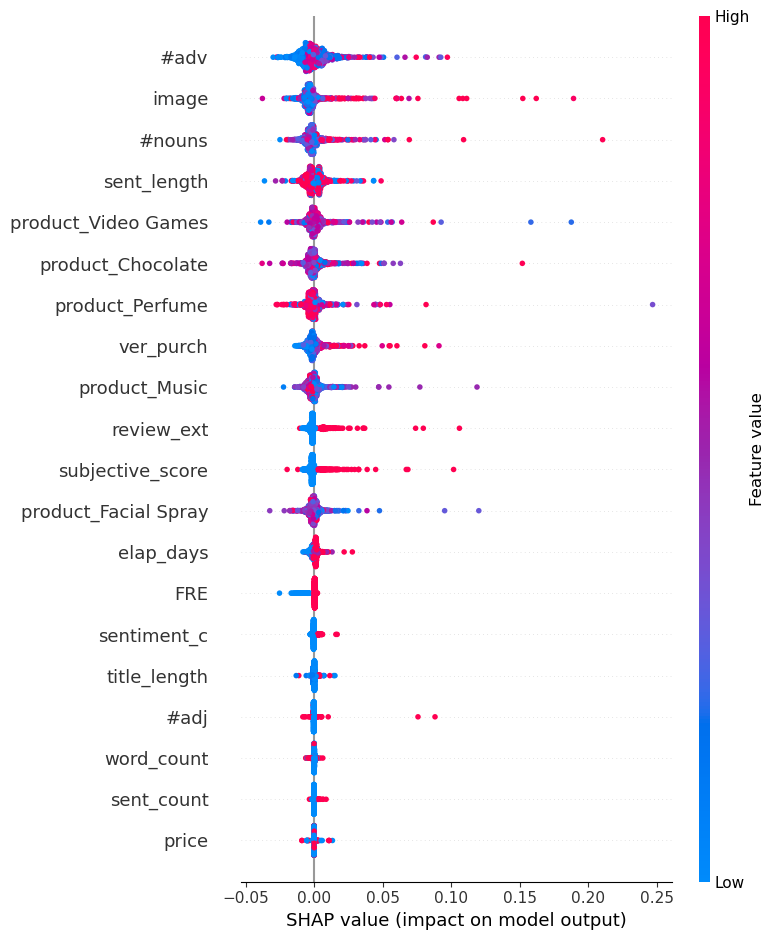

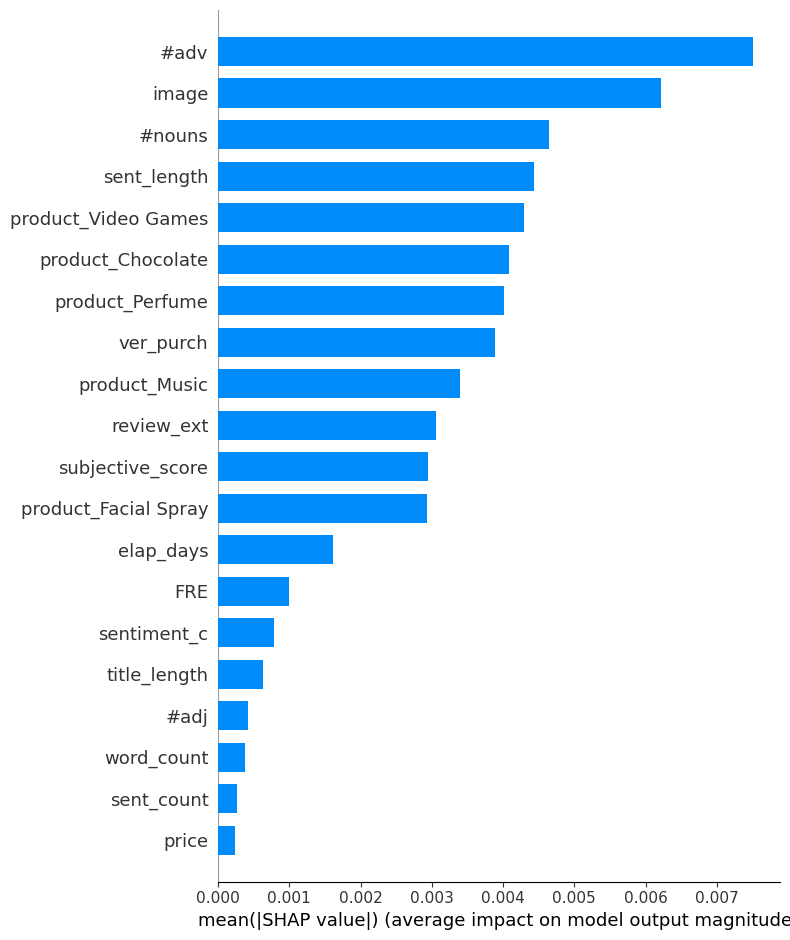

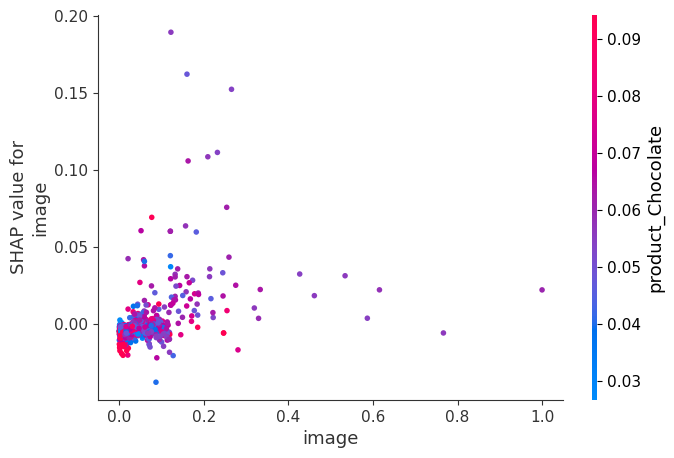

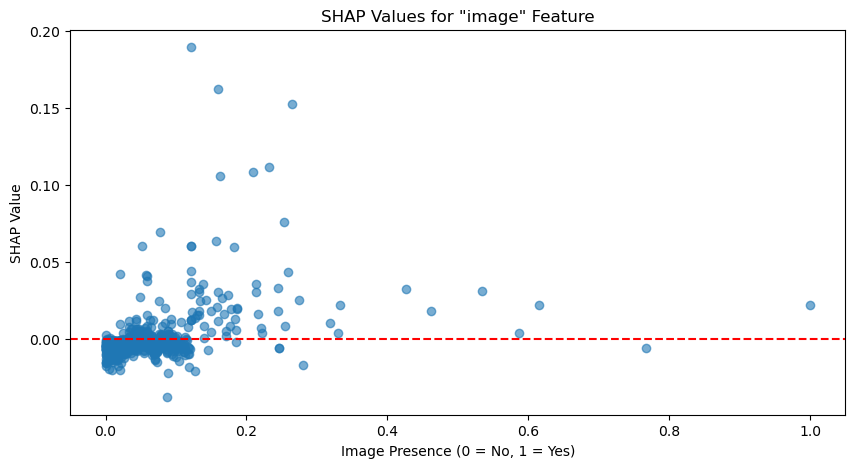

In [25]:
# Create SHAP explainer
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the dataset
shap_values = explainer.shap_values(X_train_scaled_df)

# Plot the SHAP summary plot
shap.summary_plot(shap_values, X_train_scaled_df)

# Create a beeswarm plot
shap.summary_plot(shap_values, X_train_scaled_df, plot_type="bar", show=False)
plt.show()

# Plot specifically for the 'image' feature
shap.dependence_plot('image', shap_values, X_train_scaled_df)

# Extract SHAP values for the 'image' feature
image_shap_values = shap_values[:, X_train_scaled_df.columns.get_loc('image')]

# Plot SHAP values for 'image'
plt.figure(figsize=(10, 5))
plt.scatter(X_train_scaled_df['image'], image_shap_values, alpha=0.6)
plt.axhline(0, color='red', linestyle='--')
plt.title('SHAP Values for "image" Feature')
plt.xlabel('Image Presence (0 = No, 1 = Yes)')
plt.ylabel('SHAP Value')
plt.show()


In [18]:
# Create the SHAP explainer for the model
explainer = shap.TreeExplainer(xgb_reg_default)

# Calculate SHAP values for the training set
shap_values_train = explainer.shap_values(X_train_scaled_df)


[08:19:25] WARNING: /var/folders/nz/j6p8yfhx1mv_0grj5xl4650h0000gp/T/abs_b6b50u1t0e/croot/xgboost-split_1713972723244/work/cpp_src/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.


In [19]:
# Calculate the mean of the absolute SHAP values for each feature
average_shap_values_train = np.abs(shap_values_train).mean(axis=0)


In [20]:
# Create a DataFrame for the features and their average SHAP values
shap_df_train = pd.DataFrame({
    'features': X_train_scaled_df.columns,
    'average_shap_value': average_shap_values_train
})

# Sort the DataFrame based on the average SHAP values
shap_df_train_sorted = shap_df_train.sort_values(by='average_shap_value', ascending=False)

# Display the sorted DataFrame
print(shap_df_train_sorted)

                features  average_shap_value
12                  #adv            0.007511
8                  image            0.006219
10                #nouns            0.004639
5            sent_length            0.004430
19   product_Video Games            0.004298
15     product_Chocolate            0.004085
18       product_Perfume            0.004019
9              ver_purch            0.003892
17         product_Music            0.003400
0             review_ext            0.003053
13      subjective_score            0.002947
16  product_Facial Spray            0.002927
7              elap_days            0.001612
14                   FRE            0.000996
2            sentiment_c            0.000780
6           title_length            0.000624
11                  #adj            0.000425
3             word_count            0.000373
4             sent_count            0.000272
1                  price            0.000240


In [21]:
# Calculate SHAP values for the test set
shap_values_test = explainer.shap_values(X_test_scaled_df)


NameError: name 'X_test_scaled_df' is not defined

In [ ]:
# Loop through each instance in the test set
for example_index in range(len(X_test)):
    # Extract SHAP values for the specific instance
    example_shap_values = shap_values_test[example_index]
    # Extract the corresponding predicted and actual value for the instance
    predicted_value = y_pred_default[example_index]
    actual_value = y_test[example_index]

    # Create a DataFrame for plotting
    shap_values_df = pd.DataFrame({
        'feature': X_test_scaled_df.columns,
        'shap_value': example_shap_values
    })

    # Sort the DataFrame based on the SHAP values
    shap_values_df_sorted = shap_values_df.sort_values(by='shap_value', ascending=True)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(shap_values_df_sorted['feature'], shap_values_df_sorted['shap_value'], color='skyblue')
    plt.xlabel('SHAP Value')
    # Include predicted and actual value in the title
    plt.title(f'SHAP Values for Instance Index {example_index}\nPredicted: {predicted_value:.2f}, Actual: {actual_value[0]:.2f}')
    plt.grid(True)
    plt.show()
